This version of the code is meant for the newer datasets where there is a significant trend in the dT histograms per cluster. There is no filtering here as all energy cuts are already applied to these datasets.



Guide to using this notebook:


*   Set parameters in the cell below
*   Run the sections Imports and mounts and Definitions

the notebook is now functional; 2D histogram code for single delay dataset or iteration over all implemented, as well as per-cluster dT histogram for all datasets (runtime ~5 minutes)




In [1]:
#Parameters

numclusters = 3     #Number of clusters to be used in ML_clustering function
Gaussians = True    #Determines whether gaussians are fitted to histogram distributions
bins = 30           #Number of bins in cluster histogram
threshold = 0.02    #Percentage of peak and bottom of dataset (dT) to be removed: significantly improves gaussian fit
bins2d = 75         #Number of bins used for each axis for the 2D histograms

# Imports and mounts


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.optimize as sop
import scipy.stats as sps
import scipy.cluster.hierarchy as hcluster
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import norm
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

# Definitions

In [3]:
def ML_clustering(wavedata, numclusters, numplots = 750, PCAcomponents = 2, Histplots = False, PCAplots = False, MLplots = False, Corr_rate = True):
    """
    takes a waveform dataset as input, performs PCA analysis and uses this data to perform KMeans and hierarchical clustering.
    can return graphs of both respective clustering results. NB! This function also uses a "filtereddata" dataset, which is the
    same dataset as wavedata but containing any other columns of interest (E, dT, Ch etc.).

    Parameters:
    -wavedata: waveform dataset of the type Pandas DataFrame to be used for clustering (should only contain amplitudes)
    -numclusters: number of clusters the algorithms will classify the dataset into. current colormap supports up to 10 clusters.
    -numplots: if MLplots is enabled, this is the number of plots plotted in the final graph showcasing the waveforms in the color of their class.
    -PCAcomponents: number of principal components used for analysis. first 2 used for visualization and regularly capture 95% of the information.
    -Histplots: no current functionality
    -PCAplots: if enabled, will return graph of information captured as a function of PCAcomponents
    -MLplots: if enabled, returns plots of outputs from both algorithms as well as waveform plots with waveforms shown in color of assigned cluster.


    """
    numclusters = numclusters
    pca = PCA(n_components=PCAcomponents)
    data_pca = pca.fit_transform(wavedata)
    var1, var2 = pca.explained_variance_ratio_*100

    var_ratio = []
    nums = np.arange(10)

    for num in nums:
        pca = PCA(n_components=num)
        pca.fit(wavedata)
        var_ratio.append(np.sum(pca.explained_variance_ratio_))

    if PCAplots == True:
        PCAfig, PCAplot = plt.subplots(figsize=(4, 3), dpi=150)
        PCAplot.grid()
        PCAplot.plot(nums, var_ratio, marker='o')
        PCAplot.plot(np.linspace(0, 9, 2), [0.95]*2, linestyle="dotted", label="95% variance")
        PCAplot.legend()
        PCAplot.set_xlabel('n_components')
        PCAplot.set_ylabel('Explained variance ratio')
        PCAplot.set_title('n_components vs. Explained Variance Ratio')
    else:
        pass

    mypca = PCA(n_components=2)
    PC = mypca.fit_transform(wavedata)

    filtereddata['PC1'] = PC[:,0]
    filtereddata['PC2'] = PC[:,1]

    #KMeans

    myKmeans = KMeans(n_clusters=numclusters, init='k-means++', random_state = 69)
    myKmeans.fit(PC)
    kmeans = myKmeans.fit(PC)

    kmeans_means = calculatemeans(PC, myKmeans.labels_)
    kmeans_labels_sorted = np.argsort([mean[0] for mean in kmeans_means])
    kmeans_labels_new = np.zeros_like(myKmeans.labels_)
    for i, label in enumerate(kmeans_labels_sorted):
        kmeans_labels_new[myKmeans.labels_ == label] = i

    myKmeans.labels_ = kmeans_labels_new
    kcolors = pd.DataFrame(myKmeans.labels_, columns=['Ktype'])
    kcolors['color'] = kcolors['Ktype'].map({0: 'blueviolet', 1:'aquamarine', 2:'gold', 3: "navy", 4: "slateblue", 5: "blue", 6: "cyan", 7: "mediumspringgreen", 8: "teal", 9: "lightpink"})

    filtereddata["KMeans class"] = kmeans_labels_new

    if MLplots == True:
        prop = []
        for i in range(numclusters):
            prop.append(100 * np.count_nonzero(myKmeans.labels_==i) / len (myKmeans.labels_))

        trace = wavedata.values
        grid = plt.GridSpec(1, numclusters + 2, wspace=0.4, hspace=0.4)
        wavelist = []

        fig1 = plt.figure(figsize=(6*numclusters, 4))
        pca_plot1 = fig1.add_subplot(grid[0, 0:2])
        fig1.suptitle("KMeans clustering")

        pca_plot1.scatter(x = filtereddata.PC1, y = filtereddata.PC2, s=4, c=kcolors.color)
        pca_plot1.set_xlabel(f'PC$_1$ = {var1:2.1f} %');
        pca_plot1.set_ylabel(f'PC$_2$ = {var2:2.1f} %');

        for j in range(numclusters):
            wave_j = fig1.add_subplot(grid[0, j+2])
            wavelist.append(wave_j)
            wave = list()
            idx = np.where(kcolors.Ktype==j)
            for i in idx[0]:
                mytrace = trace[i]
                wave_j.plot(mytrace, lw=0.5, color = color_map.get(j), alpha=0.05)
                wave.append(mytrace)
            wave_j.plot(np.mean(wave, axis=0), color = color_map.get(j))
            wave_j.text(x = 0, y = .5, s = f'{prop[j]:2.2f}%', color = color_map.get(j))

        for wave in wavelist:
            wave.axis('off')
    else:
        pass

    #Hierarchy

    link = linkage(PC, method = 'ward')
    trace = wavedata.values
    mylabels = fcluster(link, numclusters, criterion='maxclust')-1
    hierarchical_means = calculatemeans(PC, mylabels)
    hierarchical_labels_sorted = np.argsort([mean[0] for mean in hierarchical_means])
    hierarchical_labels_new = np.zeros_like(mylabels)
    for i, label in enumerate(hierarchical_labels_sorted):
        hierarchical_labels_new[mylabels == label] = i

    mylabels = hierarchical_labels_new
    filtereddata["Hierarchy class"] = mylabels

    if MLplots == True:
        prop = []
        for i in range(numclusters):
            prop.append(100 * np.count_nonzero(mylabels==i) / len (mylabels))
        grid = plt.GridSpec(1, numclusters + 2, wspace=0.4, hspace=0.4)
        trace = wavedata.values
        wavelist = []
        dcolors = pd.DataFrame(mylabels, columns=['Dtype'])
        dcolors['color'] = dcolors['Dtype'].map({0: 'blueviolet', 1: 'aquamarine', 2: 'gold', 3: 'navy', 4: "slateblue",5: "blue",6: "cyan",7: "mediumspringgreen", 8: "teal", 9: "lightpink"})

        fig2 = plt.figure(figsize=(6*numclusters, 4))
        pca_plot2 = fig2.add_subplot(grid[0, 0:2])
        fig2.suptitle("Hierarchical clustering")



        pca_plot2.scatter(x = filtereddata.PC1, y = filtereddata.PC2, s=4, c=dcolors.color)
        pca_plot2.set_xlabel(f'PC$_1$ = {var1:2.1f} %');
        pca_plot2.set_ylabel(f'PC$_2$ = {var2:2.1f} %');

        for j in range(numclusters):
            wave_j = fig2.add_subplot(grid[0, j+2])
            wavelist.append(wave_j)
            wave = list()
            idx = np.where(mylabels == j)
            for i in idx[0]:
                mytrace = trace[i]
                wave_j.plot(mytrace, lw=0.5, color = color_map.get(filtereddata["Hierarchy class"].iloc[i],"black"), alpha=0.05)
                wave.append(mytrace)
            wave_j.plot(np.mean(wave, axis=0), color = color_map.get(j))
            wave_j.text(x = 0, y = .5, s = f'{prop[j]:2.2f}%', color = color_map.get(j))

        for wave in wavelist:
            wave.axis('off')
    else:
        pass

    #Visualization
    if MLplots == True:
        time = np.linspace(0,1,wavedata.shape[1])
        fig3, ax = plt.subplots(1,2,figsize = (15,6))
        if numplots > filtereddata.shape[0]:
            numplots = filtereddata.shape[0]
            print(f"Given value of numplots exceeds the number of waveforms in the dataset. All waveforms were used ({filtereddata.shape[0]}).")

        for i in range(numplots):
            ax[0].plot(time,filtereddata.filter(regex='^s')[i:][:1].values.flatten().tolist(),color=color_map.get(filtereddata["KMeans class"].iloc[i], 'black'))
            ax[1].plot(time,filtereddata.filter(regex='^s')[i:][:1].values.flatten().tolist(),color=color_map.get(filtereddata["Hierarchy class"].iloc[i], 'black'))

        ax[0].set_title("Kmeans classification")
        ax[1].set_title("Hierarchy classification")
        ax[0].set_xlabel("Time")
        ax[1].set_xlabel("Time")
        ax[0].set_ylabel("Amplitude")
        ax[1].set_ylabel("Amplitude")

    #Correspondence rate

    if Corr_rate == True:
        compcount = (filtereddata['KMeans class'] == filtereddata['Hierarchy class']).sum()

        print(f"{compcount} out of {wavedata.shape[0]} waveforms were clustered in equivalent classes according to KMeans and Hierarchy. This gives a {compcount/wavedata.shape[0]*100:.2f}% correspondence rate.")

        corr_rate = {'Number of clusters': [2,3,4,5,6,7,8,9,10], 'Correspondence': [0.9679,0.7802,0.9647,0.8334,0.8532,0.7949,0.7279,0.7445,0.6898]}
        correspondence = pd.DataFrame(data=corr_rate)
    
    return np.array(pca.components_);

In [4]:
#Various functions

def plot_radii(mykmeans, X, ax = None):
    """
    Plots k-centroids from a kmeans model
    """

    ax = ax or plt.gca()

    labels = mykmeans.labels_

    centers = mykmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)]

    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='gray', lw=1, alpha=0.05, zorder=1))

def calculatemeans(X, labels):
    unique_labels = np.unique(labels)
    mean_values = []
    for label in unique_labels:
        mean_values.append(np.mean(X[labels == label], axis=0))
    return mean_values

In [5]:
#Color maps

color_map = {0: 'blueviolet', 1: 'aquamarine', 2: 'gold', 3: 'navy', 4: "slateblue",5: "blue",6: "cyan",7: "mediumspringgreen", 8: "teal", 9: "lightpink"}

# Applications

In [7]:
#Importing particular dataset
delay = "30"
#possible delay values: 06, 07, 08, 10, 20, 30, 40, 50, 60

data = pd.read_csv(f'./Martin/20231110-Na22-d0-12-ML-Tz6-100ns-ecf-{delay}.csv',sep=',')

filtereddata = data
wavedata = filtereddata.drop(columns = ["E","dT","Ch"])

(9, 128)


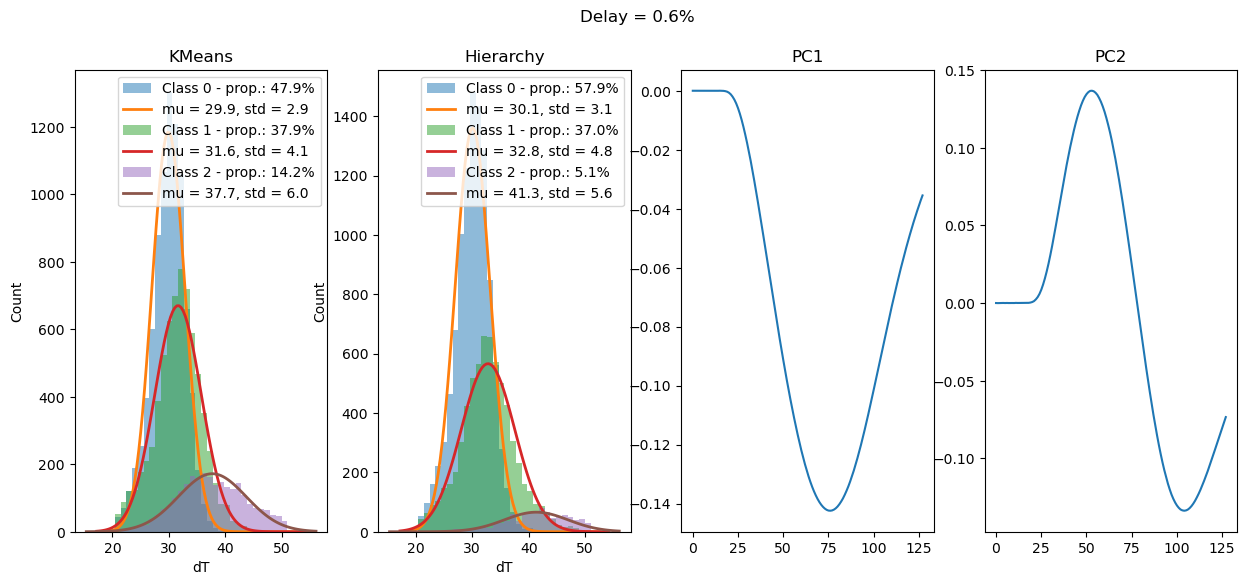

In [30]:
delays = []
for filename in os.listdir("./Martin"):
    if filename.endswith("csv"):
        # Your code comes here such as
        name = filename[37:][:2]
        delays.append(name)

for k in range(len(delays)):
    fig, ax = plt.subplots(1, 4, figsize = (15,6))
    data = pd.read_csv(f'./Martin/20231110-Na22-d0-12-ML-Tz6-100ns-ecf-{delays[k]}.csv',sep=',')
    filtereddata = data
    wavedata = data.drop(columns = ["E","dT","Ch"])
    pcacomp = ML_clustering(wavedata, numclusters, Corr_rate = False)
    print(np.shape(pcacomp))
    #pcacomp.savetxt("pca_components.csv",pcacomp,delimiter=",");
    df = pd.DataFrame(pcacomp)
    df.describe()
    df.to_csv("pca_components.csv")

    if int(delays[k][0]) == 0:
        fig.suptitle(f"Delay = {round(int(delays[k][1])*0.1,1)}%")
    if int(delays[k][0]) != 0:
        fig.suptitle(f"Delay = {int(int(delays[k])*0.1)}%")


    lower_quantile = filtereddata['dT'].quantile(threshold)
    upper_quantile = filtereddata['dT'].quantile(1-threshold)

    # Filter the DataFrame
    filtereddata = filtereddata[(filtereddata['dT'] >= lower_quantile) & (filtereddata['dT'] <= upper_quantile)]
    filtereddata_dT = []
    Gaussians = True
    bins = 30
    #Tmin = dTlims[int((delay - 30)/10)][0]
    #Tmax = dTlims[int((delay - 30)/10)][1]
    Tmin = min(filtereddata["dT"].tolist())
    Tmax = max(filtereddata["dT"].tolist())
    bin_width = (Tmax-Tmin)/bins

    for i in range(numclusters):
        filtereddata_dT.append(filtereddata["dT"][filtereddata["KMeans class"] == i][(filtereddata["dT"] < Tmax) & (filtereddata["dT"] > Tmin)])
    for i in range(numclusters):
        filtereddata_dT.append(filtereddata["dT"][filtereddata["Hierarchy class"] == i][(filtereddata["dT"] < Tmax) & (filtereddata["dT"] > Tmin)])


    for i in range(numclusters):
        ax[0].hist(filtereddata_dT[i], bins = bins, range = [Tmin,Tmax], alpha=0.5, label=f'Class {i} - prop.: {round(100 * np.count_nonzero(filtereddata["KMeans class"]==i) / filtereddata.shape[0],1)}%')
        ax[1].hist(filtereddata_dT[i+numclusters], bins = bins, range = [Tmin,Tmax], alpha=0.5, label=f'Class {i} - prop.: {round(100 * np.count_nonzero(filtereddata["Hierarchy class"]==i) / filtereddata.shape[0],1)}%')
        if Gaussians == True:
            mu1, std1 = norm.fit(filtereddata_dT[i])
            mu2, std2 = norm.fit(filtereddata_dT[i+numclusters])
            xmin, xmax = ax[0].get_xlim()
            x = np.linspace(xmin, xmax, 100)
            p1 = norm.pdf(x, mu1, std1)* len(filtereddata_dT[i]) * bin_width
            p2 = norm.pdf(x, mu2, std2)* len(filtereddata_dT[i+numclusters]) * bin_width
            ax[0].plot(x, p1, linewidth=2,label = f"mu = {mu1:.1f}, std = {std1:.1f}")
            ax[1].plot(x, p2, linewidth=2,label = f"mu = {mu2:.1f}, std = {std2:.1f}")

    for i in range(2):
        ax[i].legend(loc = "upper right")
        ax[i].set_xlabel("dT")
        ax[i].set_ylabel("Count")

    ax[2].plot(pcacomp[0,:]);
    ax[2].set_title("PC1")
    ax[3].plot(pcacomp[1,:]);
    ax[3].set_title("PC2")
        
    ax[0].set_title("KMeans")
    ax[1].set_title("Hierarchy")

    plt.show()

In [ ]:
delay = "60"
#possible delay values: 06, 07, 08, 10, 20, 30, 40, 50, 60

data = pd.read_csv(f'/content/drive/MyDrive/Bach_students_share/Martin/20231110-Na22-d0-12-ML-Tz6-100ns-ecf-{delay}.csv',sep=',')

filtereddata = data
wavedata = filtereddata.drop(columns = ["E","dT","Ch"])

ML_clustering(wavedata,3,MLplots = True)

# 2D Histogram

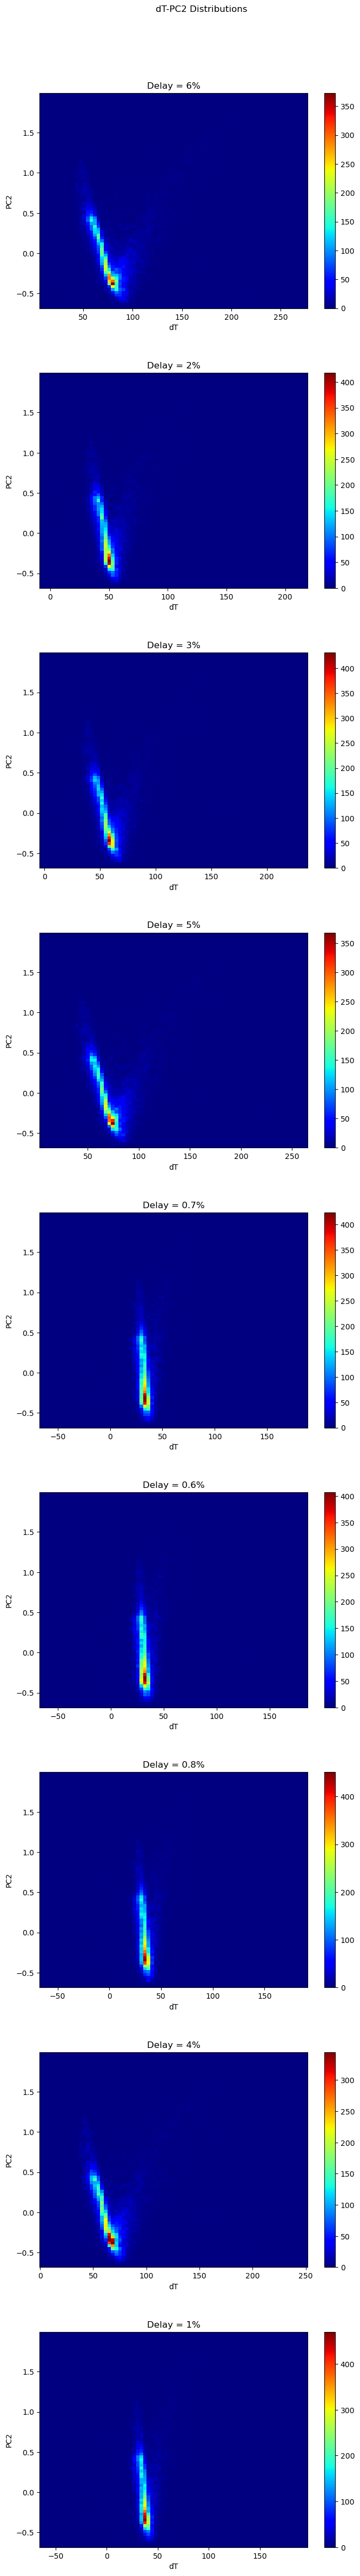

In [10]:
firstcol = "dT"
secondcol = "PC2"
"""
dT = filtereddata["dT"].tolist()
PC = filtereddata[secondcol].tolist()
"""
delays = []
for filename in os.listdir("./Martin"):
    if filename.endswith("csv"):
        # Your code comes here such as
        name = filename[37:][:2]
        delays.append(name)

fig, ax = plt.subplots(len(delays),figsize = (8,6*len(delays)))

for k in range(len(delays)):
    data = pd.read_csv(f'./Martin/20231110-Na22-d0-12-ML-Tz6-100ns-ecf-{delays[k]}.csv',sep=',')
    filtereddata = data
    wavedata = data.drop(columns = ["E","dT","Ch"])
    ML_clustering(wavedata, numclusters, Corr_rate = False)


    h = ax[k].hist2d(filtereddata[firstcol].tolist(),filtereddata[secondcol].tolist(),bins = (bins2d,bins2d),cmap = plt.cm.jet)
    ax[k].set_xlabel(firstcol)
    ax[k].set_ylabel(secondcol)
    fig.colorbar(h[3], ax=ax[k])
    if int(delays[k][0]) == 0:
        ax[k].set_title(f"Delay = {round(int(delays[k][1])*0.1,1)}%")
    if int(delays[k][0]) != 0:
        ax[k].set_title(f"Delay = {int(int(delays[k])*0.1)}%")

plt.subplots_adjust(top=0.95, hspace=0.3)
fig.suptitle(f"{firstcol}-{secondcol} Distributions")
plt.show()

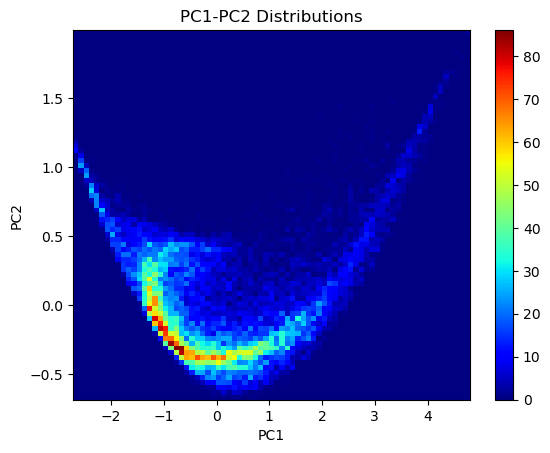

In [11]:
firstcol = "PC1"
secondcol = "PC2"

plt.hist2d(filtereddata[firstcol].tolist(),filtereddata[secondcol].tolist(),bins = (bins2d,bins2d),cmap = plt.cm.jet)
plt.xlabel(firstcol)
plt.ylabel(secondcol)
plt.colorbar()
plt.title(f"{firstcol}-{secondcol} Distributions")
plt.show()
